# Dataset example

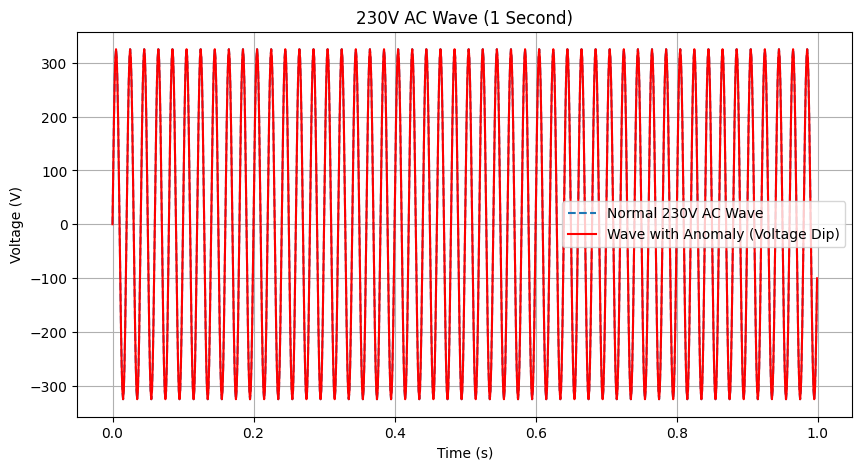

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Define parameters for the 230V AC time series
duration = 1  # 1 second duration
time_resolution = 0.001  # 0.1 millisecond resolution for high fidelity
time = np.arange(0, duration, time_resolution)  # time from 0 to 1 second
anomaly_probability = 0.0009

frequency = 50  # 50 Hz frequency
amplitude = 230 * np.sqrt(2)  # Peak amplitude for 230V RMS (~325V)

# Generate the normal sinusoidal wave
normal_wave = amplitude * np.sin(2 * np.pi * frequency * time)

anomaly_wave = np.copy(normal_wave)
for i in range(len(time)):
    if np.random.rand() < anomaly_probability:
        # Create an anomaly at this point: e.g., a sudden drop in voltage for a short duration
        end_index = min(i + 100, len(time))  # The anomaly will last for a small time period (100 points)
        anomaly_wave[i:end_index] = anomaly_wave[i:end_index] * 0.2  # 80% dip in voltage

# Plot the wave over 1 second
plt.figure(figsize=(10, 5))
plt.plot(time, normal_wave, label='Normal 230V AC Wave', linestyle='--')
plt.plot(time, anomaly_wave, label='Wave with Anomaly (Voltage Dip)', color='red')
plt.title('230V AC Wave (1 Second)')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.grid(True)
plt.legend()
plt.show()

# Generate dataset

CSV file saved at: dataset.csv


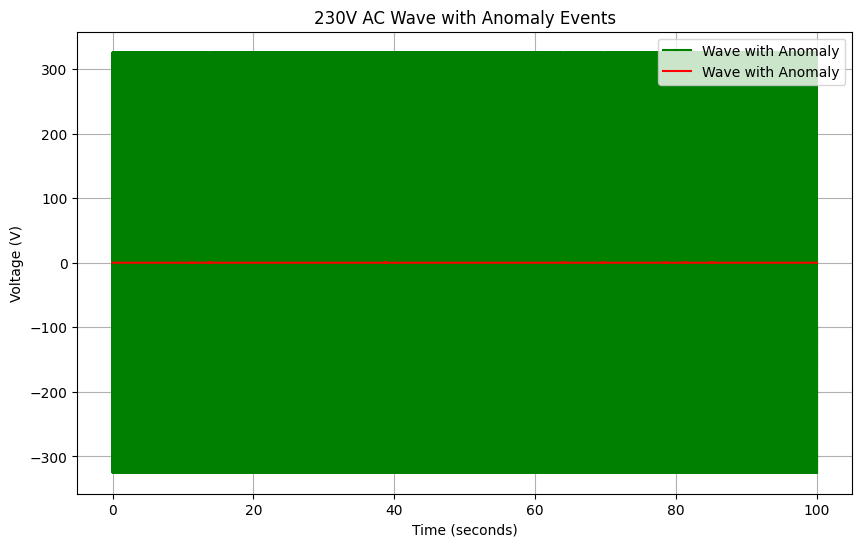

Number of anomaly events: 8


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define parameters for the 230V AC time series
duration = 100  # 1 second duration
time_resolution = 0.001  # 0.1 millisecond resolution for high fidelity
time = np.arange(0, duration, time_resolution)  # time from 0 to 1 second
anomaly_probability = 0.00009

frequency = 50  # 50 Hz frequency
amplitude = 230 * np.sqrt(2)  # Peak amplitude for 230V RMS (~325V)

# Generate the normal sinusoidal wave
normal_wave = amplitude * np.sin(2 * np.pi * frequency * time)

anomaly_wave = np.copy(normal_wave)
labels = np.zeros_like(time, dtype=int)  # 0 for normal, 1 for anomaly

# Generate anomalies
in_anomaly = False
for i in range(len(time)):
    if np.random.rand() < anomaly_probability and not in_anomaly:
        # Create an anomaly at this point: e.g., a sudden drop in voltage for a short duration
        end_index = min(i + 100, len(time))  # The anomaly will last for a small time period (100 points)
        anomaly_wave[i:end_index] = anomaly_wave[i:end_index] * 0.2  # 80% dip in voltage
        labels[i:end_index] = 1 
        in_anomaly = True
    elif labels[i] == 0:
        in_anomaly = False

data = {
    'time': time,
    'normal_wave': normal_wave,
    'anomaly_wave': anomaly_wave,
    'is_anomaly': labels
}

df = pd.DataFrame(data)

# Save the dataset to CSV
csv_file_path = "dataset.csv"
df.to_csv(csv_file_path, index=False)

print(f"CSV file saved at: {csv_file_path}")

def count_anomaly_events(labels):
    anomaly_events = 0
    in_anomaly = False

    for label in labels:
        if label == 1 and not in_anomaly:
            anomaly_events += 1
            in_anomaly = True
        elif label == 0:
            in_anomaly = False

    return anomaly_events

def plot_with_anomaly_events(time, anomaly_wave, labels):
    plt.figure(figsize=(10, 6))
    
    # Plot the anomaly wave
    plt.plot(time, anomaly_wave, label='Wave with Anomaly', color='green')

    plt.plot(time, labels, label='Wave with Anomaly', color='red')
    
    plt.title('230V AC Wave with Anomaly Events')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Voltage (V)')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_with_anomaly_events(time, anomaly_wave, labels)

print(f"Number of anomaly events: {count_anomaly_events(labels)}")

# Let's develop a simple model to detect anomalies

Anomaly detection threshold (KL Divergence): 0.010199148586751076
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000


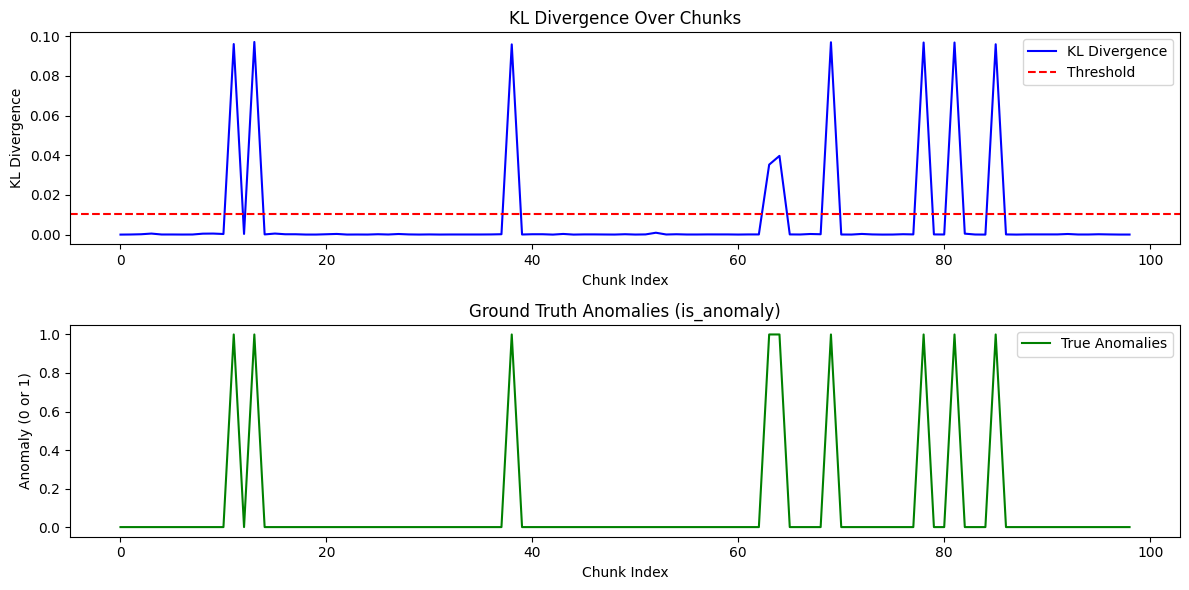

In [18]:
import numpy as np
import pandas as pd
from scipy.stats import entropy
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Function to find the zero crossings of a signal
def find_zero_crossings(signal):
    zero_crossings = np.where(np.diff(np.sign(signal)))[0]
    return zero_crossings

# Function to trim the signal to start and end at zero crossings
def trim_to_zero_crossings(signal):
    zero_crossings = find_zero_crossings(signal)
    if len(zero_crossings) >= 2:
        return signal[zero_crossings[0]:zero_crossings[-1]]
    else:
        return signal

df = pd.read_csv('dataset.csv')

sampling_rate = 1000
chunk_size = sampling_rate  # 1 second chunk size

window_size = chunk_size
step_size = 1000  # 1-second overlap
normal_chunks = []
for i in range(0, len(df) - window_size, step_size):
    chunk = df['normal_wave'].iloc[i:i + window_size].values
    trimmed_chunk = trim_to_zero_crossings(chunk)
    normal_chunks.append(trimmed_chunk)

anomaly_chunks = []
for i in range(0, len(df) - window_size, step_size):
    chunk = df['anomaly_wave'].iloc[i:i + window_size].values
    trimmed_chunk = trim_to_zero_crossings(chunk)
    anomaly_chunks.append(trimmed_chunk)

def compute_histogram(data, bins=50):
    hist, bin_edges = np.histogram(data, bins=bins, density=True)
    hist = hist + 1e-10  # Avoid division by zero
    return hist, bin_edges

def compute_kl_divergence(p, q):
    return entropy(p, q)

normal_wave = normal_chunks[0]
p_hist, p_bins = compute_histogram(normal_wave)

kl_divergences = []
for anomaly_wave in anomaly_chunks:
    q_hist, q_bins = compute_histogram(anomaly_wave)
    kl_div = compute_kl_divergence(p_hist, q_hist)
    kl_divergences.append(kl_div)

kl_threshold = np.mean(kl_divergences) + 0.1 * np.std(kl_divergences)
print(f"Anomaly detection threshold (KL Divergence): {kl_threshold}")

anomaly_predictions = np.array(kl_divergences) > kl_threshold

ground_truth_chunks = []
for i in range(0, len(df) - window_size, step_size):
    chunk_ground_truth = df['is_anomaly'].iloc[i:i + window_size].values
    ground_truth_chunks.append(np.max(chunk_ground_truth))

ground_truth_chunks = np.array(ground_truth_chunks)
accuracy = accuracy_score(ground_truth_chunks, anomaly_predictions)
precision = precision_score(ground_truth_chunks, anomaly_predictions)
recall = recall_score(ground_truth_chunks, anomaly_predictions)
f1 = f1_score(ground_truth_chunks, anomaly_predictions)

# Print the evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(kl_divergences, label='KL Divergence', color='b')
plt.axhline(y=kl_threshold, color='r', linestyle='--', label='Threshold')
plt.title('KL Divergence Over Chunks')
plt.xlabel('Chunk Index')
plt.ylabel('KL Divergence')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(ground_truth_chunks, label='True Anomalies', color='g')
plt.title('Ground Truth Anomalies (is_anomaly)')
plt.xlabel('Chunk Index')
plt.ylabel('Anomaly (0 or 1)')
plt.legend()

plt.tight_layout()
plt.show()

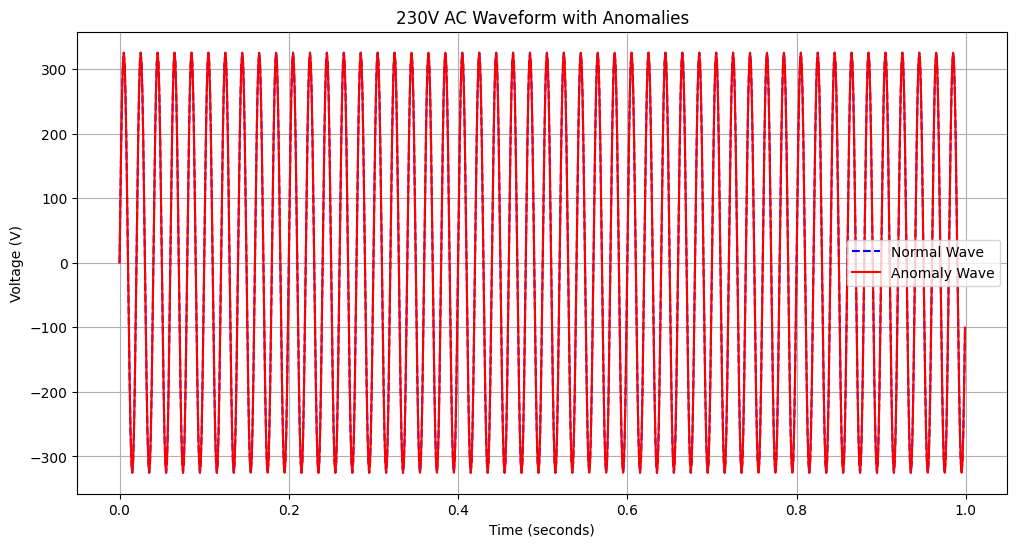

    time  normal_wave  anomaly_wave  is_anomaly
0  0.000     0.000000      0.000000           0
1  0.001   100.513686    100.513686           0
2  0.002   191.188391    191.188391           0
3  0.003   263.148245    263.148245           0
4  0.004   309.349316    309.349316           0


In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def generate_single_sample(duration=1, sampling_rate=1000, frequency=50, amplitude=230, 
                           anomaly_probability=0.0001, anomaly_duration=100, anomaly_drop=0.2):
    time = np.arange(0, duration, 1/sampling_rate)

    normal_wave = amplitude * np.sqrt(2) * np.sin(2 * np.pi * frequency * time)
    anomaly_wave = np.copy(normal_wave)
    labels = np.zeros_like(time, dtype=int)
    
    in_anomaly = False
    for i in range(len(time)):
        if np.random.rand() < anomaly_probability and not in_anomaly:
            end_index = min(i + anomaly_duration, len(time))
            anomaly_wave[i:end_index] = anomaly_wave[i:end_index] * anomaly_drop
            labels[i:end_index] = 1
            in_anomaly = True
        elif labels[i] == 0:
            in_anomaly = False
    
    data = {
        'time': time,
        'normal_wave': normal_wave,
        'anomaly_wave': anomaly_wave,
        'is_anomaly': labels
    }
    
    df = pd.DataFrame(data)
    
    plt.figure(figsize=(12, 6))
    
    plt.plot(df['time'], df['normal_wave'], label='Normal Wave', linestyle='--', color='blue')
    plt.plot(df['time'], df['anomaly_wave'], label='Anomaly Wave', color='red')
    
    for i in range(len(df['is_anomaly'])):
        if df['is_anomaly'][i] == 1 and (i == 0 or df['is_anomaly'][i - 1] == 0):
            start = i
        if df['is_anomaly'][i] == 0 and (i > 0 and df['is_anomaly'][i - 1] == 1):
            plt.axvspan(df['time'][start], df['time'][i], color='red', alpha=0.3, label='Anomaly')

    plt.title('230V AC Waveform with Anomalies')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Voltage (V)')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return df

# Example usage:
sample_df = generate_single_sample(duration=1, sampling_rate=1000, frequency=50, amplitude=230, 
                                   anomaly_probability=0.0001, anomaly_duration=100, anomaly_drop=0.2)

print(sample_df.head())


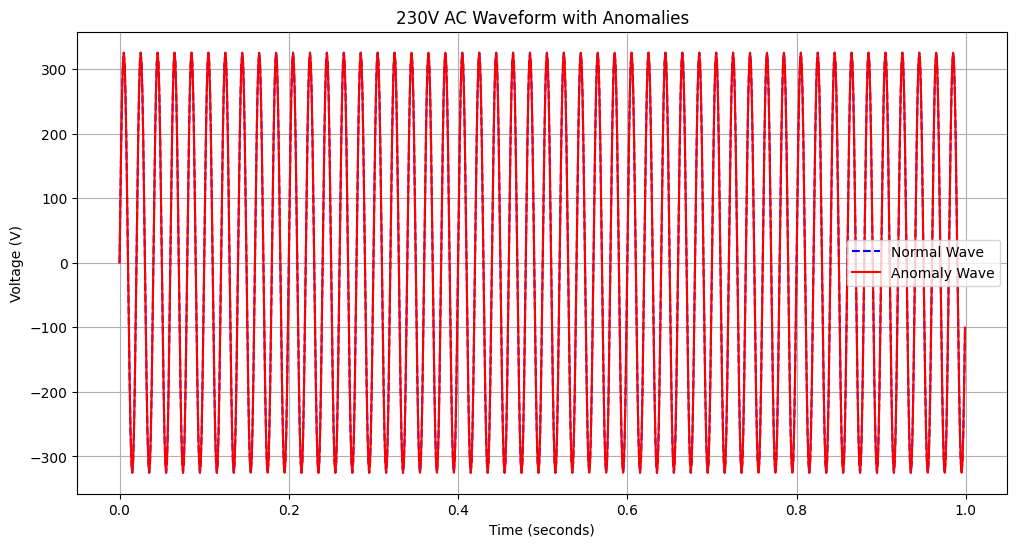

Anomaly detected: False
KL Divergence: 0.0


In [26]:
import numpy as np
import pandas as pd
from scipy.stats import entropy

reference_wave_global = None

def set_reference_wave(reference_wave):
    global reference_wave_global
    reference_wave_global = reference_wave

def compute_histogram(data, bins=50):
    hist, bin_edges = np.histogram(data, bins=bins, density=True)
    hist = hist + 1e-10  # Avoid division by zero
    return hist, bin_edges

def compute_kl_divergence(p, q):
    return entropy(p, q)

def detect_anomaly(sample_wave, kl_threshold=0.010199148586751076):
    global reference_wave_global
    
    if reference_wave_global is None:
        raise ValueError("Reference wave has not been set. Use 'set_reference_wave()' to set the reference.")

    sample_hist, _ = compute_histogram(sample_wave)
    reference_hist, _ = compute_histogram(reference_wave_global)
    kl_div = compute_kl_divergence(reference_hist, sample_hist)
    anomaly_detected = kl_div > kl_threshold
    
    return anomaly_detected, kl_div

sample_df = generate_single_sample(duration=1, sampling_rate=1000, frequency=50, amplitude=230, 
                                   anomaly_probability=0.001, anomaly_duration=100, anomaly_drop=0.2)

reference_wave = sample_df['normal_wave'].values
set_reference_wave(reference_wave)

sample_wave = sample_df['anomaly_wave'].values
anomaly_detected, kl_divergence = detect_anomaly(sample_wave)

print(f"Anomaly detected: {anomaly_detected}")
print(f"KL Divergence: {kl_divergence}")